## Import Libraries

In [1]:
!pip install mplfinance

In [2]:
import pandas as pd
import jdatetime
import mplfinance as mpf
import matplotlib.pyplot as plt
from finpy_tse import Get_Price_History
from tkinter import filedialog
import json

## Utility function to load shapes from JSON file

In [3]:
def load_shapes_from_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        shapes = json.load(file)
    return shapes

## Fetch stock data from the Tehran Stock Exchange

In [4]:
def fetch_stock_data(symbol, start_date, end_date):
    try:
        stock_data = Get_Price_History(symbol, start_date=start_date, end_date=end_date)
        return stock_data
    except Exception as e:
        print(f"مشکلی در دریافت اطلاعات پیش آمده: {e}")
        return pd.DataFrame()

## Plot the candlestick chart with shapes (like lines, rectangles)

In [5]:
def plot_candlestick_chart(symbol, start_date, end_date, shapes_data=None):
    %matplotlib inline
    
    stock_data = fetch_stock_data(symbol, start_date, end_date)

    if stock_data.empty:
        print("دیتایی یافت نشد.")
        return
        
    gregorian_index = pd.to_datetime(stock_data.index.to_series().apply(
        lambda date: jdatetime.date(*map(int, date.split('-'))).togregorian().strftime('%Y-%m-%d')
    ))

    stock_data.index = gregorian_index

    fig, axlist = mpf.plot(stock_data, type='candle', style='charles',
                           title=f'Candlestick chart for {symbol}',
                           ylabel='Price',
                           ylabel_lower='Volume',
                           volume=True,
                           returnfig=True)

    axlist[0].set_xticks(range(0, len(stock_data), max(1, len(stock_data) // 10)))
    axlist[0].set_xticklabels([greg_date.strftime('%Y-%m-%d') for greg_date in gregorian_index[::max(1, len(stock_data) // 10)]],
                              rotation=45)

    if shapes_data:
        draw_shapes_on_chart(shapes_data, axlist[0], gregorian_index)

    plt.show()

## Function to draw shapes on the chart

In [6]:
def draw_shapes_on_chart(shapes_data, ax, gregorian_dates):
    gregorian_index = gregorian_dates.dt.strftime('%Y-%m-%d').tolist()

    for shape in shapes_data:
        start_date_shamsi = shape['start_point']['date']
        end_date_shamsi = shape['end_point']['date']

        start_date_gregorian = jdatetime.date(*map(int, start_date_shamsi.split('-'))).togregorian()
        end_date_gregorian = jdatetime.date(*map(int, end_date_shamsi.split('-'))).togregorian()

        start_date_str = start_date_gregorian.strftime('%Y-%m-%d')
        end_date_str = end_date_gregorian.strftime('%Y-%m-%d')

        nearest_start_date = find_nearest_date(start_date_str, gregorian_index)
        nearest_end_date = find_nearest_date(end_date_str, gregorian_index)

        start_index = gregorian_index.index(nearest_start_date.strftime('%Y-%m-%d'))
        end_index = gregorian_index.index(nearest_end_date.strftime('%Y-%m-%d'))

        ax.plot(start_index, shape['start_point']['price'], marker='o', color='red', label="Start Point")
        ax.plot(end_index, shape['end_point']['price'], marker='o', color='blue', label="End Point")

        if shape['shape_type'] == 'line':
            ax.plot([start_index, end_index], [shape['start_point']['price'], shape['end_point']['price']],
                    color=shape['color'], linestyle='-', linewidth=2)

        elif shape['shape_type'] == 'rectangle':
            rect = plt.Rectangle((start_index, shape['start_point']['price']),
                                 end_index - start_index,
                                 shape['end_point']['price'] - shape['start_point']['price'],
                                 color=shape['color'], fill=False)
            ax.add_patch(rect)

## Find nearest date helper function

In [7]:
def find_nearest_date(date_str, available_dates):
    available_dates = pd.to_datetime(available_dates)
    target_date = pd.to_datetime(date_str)
    pos = available_dates.searchsorted(target_date)

    if pos == 0:
        return available_dates[0]
    if pos == len(available_dates):
        return available_dates[-1]

    before = available_dates[pos - 1]
    after = available_dates[pos]
    return after if after - target_date < target_date - before else before

# مثال استفاده از کد

In [8]:
symbol = "فولاد"
start_date = "1401-01-01"
end_date = "1401-02-20"

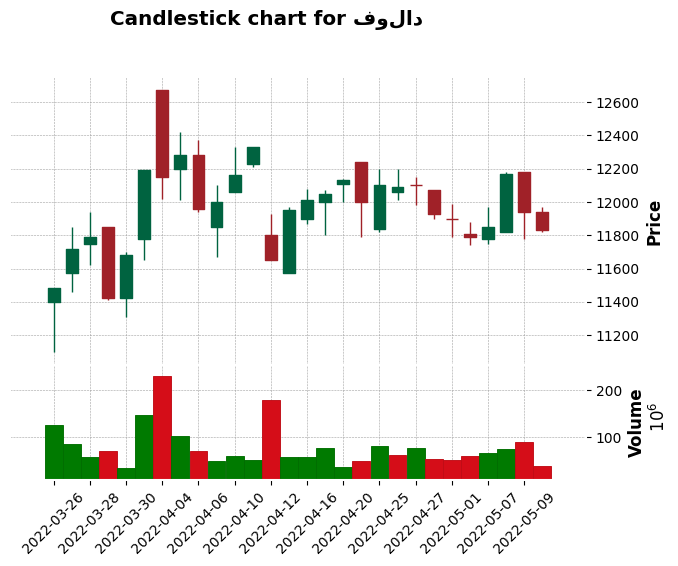

In [9]:
# رسم نمودار بدون اشکال
plot_candlestick_chart(symbol, start_date, end_date)

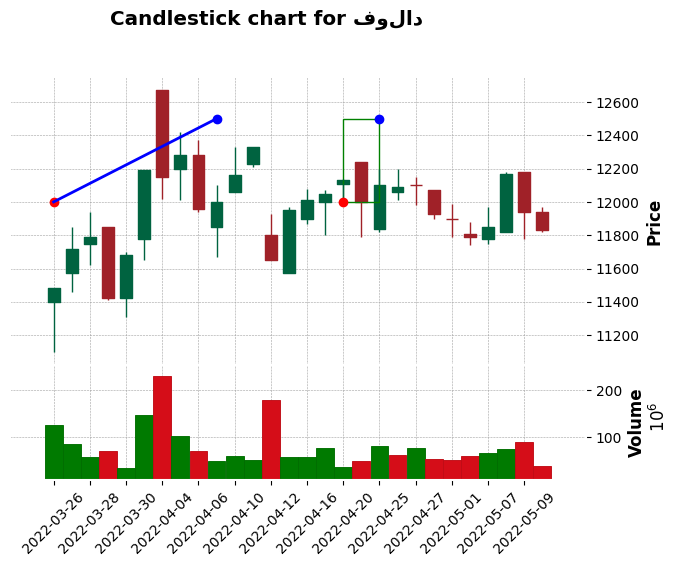

In [10]:
# بارگذاری اشکال از فایل JSON و رسم نمودار با اشکال
json_file = filedialog.askopenfilename(filetypes=[("JSON files", "*.json")])
shapes_data = load_shapes_from_json(json_file)
plot_candlestick_chart(symbol, start_date, end_date, shapes_data=shapes_data)